In [1]:
# Allow us to load `open_cp` without installing
import sys, os.path
sys.path.insert(0, os.path.abspath(".."))

# Comparison with SaTScan

Having discovered further trouble replicating the results of SaTScan, we introduce some more support for reading and writing SaTScan files, and test various corner cases.

The class `AbstractSTScan` works with "generic time" (so just numbers, now interpretted as some time unit _before_ an epoch time).  This allows us to concentrate on the details.  We also introduce a more complicated rule about cases when the boundary of a disc contains more than one point (see below).

The class `STScanNumpy` takes the same data and settings as `AbstractSTScan`, but uses a parallel `numpy` programme style to improve performance.  Like the original implementation, and unlike `AbstractSTScan`, it does nothing special about events which fall on the boundary of disks.

In the following, we set the "population" limits to 50% (the SaTScan default) and set the maximum radius and time lengths to be effectively infinity, given the inputs.  Hence these results should be directly comparable with the results from SaTScan for a "Prospective Analyses" / "Space-Time" and "Space-Time Permutation" with otherwise default options.

## Setup

- Import what we need
- Various functions to build test data and get into the various classes which implement the different algorithms.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import open_cp.stscan, open_cp.stscan2
import numpy as np

In [3]:
def make_random_data(s=100):
    times = np.floor(np.random.random(size=s) * 200)
    times.sort()
    times = np.flipud(times)
    coords = np.random.random(size=(2,s)) * 100
    return coords, times

def build_ab_scan(coords, times):
    ab_scan = open_cp.stscan2.AbstractSTScan(coords, times)
    ab_scan.geographic_radius_limit = 1000
    ab_scan.geographic_population_limit = 0.5
    ab_scan.time_max_interval = 200
    ab_scan.time_population_limit = 0.5
    return ab_scan

def build_stscan_numpy(coords, times):
    stsn = open_cp.stscan2.STScanNumpy(coords, times)
    stsn.geographic_radius_limit = 1000
    stsn.geographic_population_limit = 0.5
    stsn.time_max_interval = 200
    stsn.time_population_limit = 0.5
    return stsn

def to_timed_points(coords, times):
    """Convert to days before 2017-04-01 and use `STSTrainerSlow`."""
    timestamps = (np.timedelta64(1,"D") / np.timedelta64(1,"s")) * times * np.timedelta64(1,"s")
    timestamps = np.datetime64("2017-04-01T00:00") - timestamps
    return open_cp.data.TimedPoints(timestamps, coords)

def build_trainer(coords, times):
    trainer = open_cp.stscan.STSTrainerSlow()
    trainer.data = to_timed_points(coords, times)
    trainer.time_max_interval = np.timedelta64(200,"D")
    trainer.time_population_limit = 0.5
    trainer.geographic_population_limit = 0.5
    trainer.geographic_radius_limit = 1000
    return trainer

def build_trainer_fast(coords, times):
    trainer = open_cp.stscan.STSTrainer()
    trainer.data = to_timed_points(coords, times)
    trainer.time_max_interval = np.timedelta64(200,"D")
    trainer.time_population_limit = 0.5
    trainer.geographic_population_limit = 0.5
    trainer.geographic_radius_limit = 1000
    return trainer

# Comparison

We find that _most_ of the time, we obtain the same clusters.  But sometimes we don't.  This is down to:

- Non-deterministic ordering.  If we compare things in different orders, we can break ties in different ways.
- As the discs are always centred on events, it is possible for different discs to contain the same events.  As we generate further clusters by finding the next most significant cluster which is _disjoint_ for current clusters, if we again process things in a different order, then we can obtain different disks.

From this point of view, obtaining perfect agreement with SaTScan seems an almost hopeless ideal!

In [4]:
coords, times = make_random_data()
ab_scan = build_ab_scan(coords, times)
all_clusters = list(ab_scan.find_all_clusters())
for c in all_clusters:
    print(c.centre, c.radius, c.time, c.statistic)

[ 76.67958098  70.67303238] 6.26068819798 11.0 4.10964826268
[ 25.62506612  81.12533434] 4.98149174846 15.0 2.65052201767
[ 97.68252868  60.90292084] 9.28086184515 29.0 1.89781609396
[ 39.79954011  44.21162003] 16.7103758495 11.0 1.84967494727
[ 69.47158256  44.54198815] 5.14394282283 46.0 1.76235620726
[  5.03419207  14.31482073] 4.58123081159 18.0 1.67259335716
[ 56.1856734   80.90891644] 7.50246199343 53.0 1.21880809961
[  8.42908845  51.28704857] 10.2666146371 38.0 1.12827509444
[ 38.60612153  90.852359  ] 10.6267339429 68.0 0.970056700253
[ 59.27869325  68.6481818 ] 3.03463879562 54.0 0.771589596938
[ 62.61019443   8.62434662] 6.40089332758 55.0 0.702947397527
[ 96.34275589   6.51824075] 11.7746330291 48.0 0.581812742761
[ 61.7970058   33.56111414] 3.41047109716 69.0 0.455736816583
[ 79.31901835  58.67975208] 5.6426503678 57.0 0.245781939184


In [5]:
stsn = build_stscan_numpy(coords, times)
all_clusters = list(stsn.find_all_clusters())
for c in all_clusters:
    print(c.centre, c.radius, c.time, c.statistic)

[ 76.67958098  70.67303238] 6.26068819798 11.0 4.10964826268
[ 23.84890634  76.47124834] 4.98149174846 15.0 2.65052201767
[ 97.68252868  60.90292084] 9.28086184515 29.0 1.89781609396
[ 39.79954011  44.21162003] 16.7103758495 11.0 1.84967494727
[ 68.1665212   47.97022598] 7.66128529232 46.0 1.76235620726
[  9.49826708  13.28539852] 5.50313453631 18.0 1.67259335716
[ 47.24693564  99.75791981] 25.8752636803 68.0 1.32563264516
[  8.42908845  51.28704857] 10.2666146371 38.0 1.12827509444
[ 59.27869325  68.6481818 ] 3.03463879562 54.0 0.771589596938
[ 57.65756988  12.67933682] 6.40089332758 55.0 0.702947397527
[ 96.34275589   6.51824075] 11.7746330291 48.0 0.581812742761
[ 62.99050818  30.36629565] 3.41047109716 69.0 0.455736816583
[ 79.31901835  58.67975208] 5.6426503678 57.0 0.245781939184


In [6]:
trainer = build_trainer(coords, times)
result = trainer.predict(time=np.datetime64("2017-04-01T00:00"))
for c, t, s in zip(result.clusters, result.time_ranges, result.statistics):
    assert np.datetime64("2017-04-01T00:00") == t[1]
    t = (np.datetime64("2017-04-01T00:00") - t[0]) / np.timedelta64(1,"D")
    print(c, t, s)

Cluster(centre=array([ 76.67958098,  70.67303238]), radius=6.260750804862159) 11.0 4.10964826268
Cluster(centre=array([ 25.62506612,  81.12533434]), radius=4.9815415633814277) 15.0 2.65052201767
Cluster(centre=array([ 97.68252868,  60.90292084]), radius=9.2809546537639793) 29.0 1.89781609396
Cluster(centre=array([ 39.79954011,  44.21162003]), radius=16.71054295321839) 11.0 1.84967494727
Cluster(centre=array([ 68.1665212 ,  47.97022598]), radius=7.661361905173532) 46.0 1.76235620726
Cluster(centre=array([  5.03419207,  14.31482073]), radius=4.5812766239017328) 18.0 1.67259335716
Cluster(centre=array([ 56.1856734 ,  80.90891644]), radius=7.5025370180458051) 53.0 1.21880809961
Cluster(centre=array([  8.42908845,  51.28704857]), radius=10.266717303230743) 38.0 1.12827509444
Cluster(centre=array([ 38.60612153,  90.852359  ]), radius=10.626840210224376) 68.0 0.970056700253
Cluster(centre=array([ 59.27869325,  68.6481818 ]), radius=3.0346691420119427) 54.0 0.771589596938
Cluster(centre=array(

In [7]:
trainer_fast = build_trainer_fast(coords, times)
result_fast = trainer_fast.predict(time=np.datetime64("2017-04-01T00:00"))
for c, t, s in zip(result_fast.clusters, result_fast.time_ranges, result_fast.statistics):
    assert np.datetime64("2017-04-01T00:00") == t[1]
    t = (np.datetime64("2017-04-01T00:00") - t[0]) / np.timedelta64(1,"D")
    print(c, t, s)

Cluster(centre=array([ 76.67958098,  70.67303238]), radius=6.2606881979801789) 11.0 4.10964826268
Cluster(centre=array([ 23.84890634,  76.47124834]), radius=4.9814917484639425) 15.0 2.65052201767
Cluster(centre=array([ 97.68252868,  60.90292084]), radius=9.2808618451455267) 29.0 1.89781609396
Cluster(centre=array([ 39.79954011,  44.21162003]), radius=16.710375849459894) 11.0 1.84967494727
Cluster(centre=array([ 68.1665212 ,  47.97022598]), radius=7.6612852923206081) 46.0 1.76235620726
Cluster(centre=array([  9.49826708,  13.28539852]), radius=5.5031345363063329) 18.0 1.67259335716
Cluster(centre=array([ 47.24693564,  99.75791981]), radius=25.875263680325467) 68.0 1.32563264516
Cluster(centre=array([  8.42908845,  51.28704857]), radius=10.266614637084372) 38.0 1.12827509444
Cluster(centre=array([ 59.27869325,  68.6481818 ]), radius=3.0346387956239864) 54.0 0.771589596938
Cluster(centre=array([ 57.65756988,  12.67933682]), radius=6.4008933275835043) 55.0 0.702947397527
Cluster(centre=arr

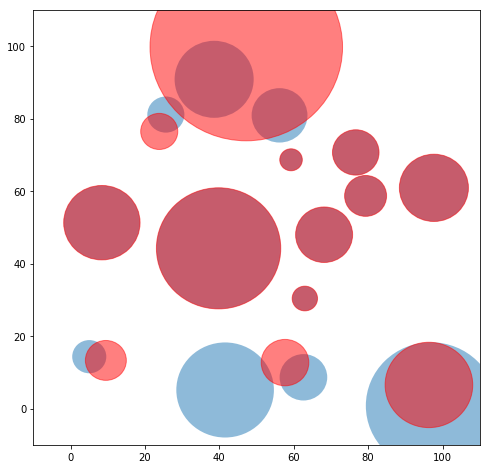

In [8]:
# Plots the old "trainer" implementation against the abstract numpy implementation

import matplotlib.patches

fig, ax = plt.subplots(figsize=(8,8))
ax.set(xlim=[-10,110], ylim=[-10,110])
for c in result.clusters:
    cir = matplotlib.patches.Circle(c.centre, c.radius, alpha=0.5)
    ax.add_patch(cir)
for c in all_clusters:
    cir = matplotlib.patches.Circle(c.centre, c.radius, alpha=0.5, color="red")
    ax.add_patch(cir)

## Timings

The newer code in `AbstractSTScan` is a bit quicker.  The Numpy code is definitely quicker.

In [9]:
%timeit( list(ab_scan.find_all_clusters()) )

1 loop, best of 3: 2.13 s per loop


In [10]:
%timeit( list(stsn.find_all_clusters()) )

10 loops, best of 3: 46.1 ms per loop


In [11]:
%timeit( trainer.predict() )

1 loop, best of 3: 2.61 s per loop


In [12]:
%timeit( trainer_fast.predict() )

10 loops, best of 3: 48.8 ms per loop


## Optionally save

We can write the data out in SaTScan format for comparison purposes.  Be sure to adjust Advanced Analysis options in SaTScan to reflect the settings we used above (no limit of size of clusters, but a population limit of 50% for both space and time).~

In [ ]:
#ab_scan.to_satscan("satscan_test2", 1000)

# Grided data

Where we have found quite different behaviour from SaTScan is in "boundary" behaviour.  Consider the case when a disk's boundary (it's circumference) contains more than one event.  The `STSTrainer` class always considers all events inside or on the edge of the disk.  But SaTScan will _sometimes_ consider events inside the disc, and then only _some_ of the events on the boundary.

Notice in particular that we can expect this to happen a lot if the input data is on a regular grid.

We try to replicate this behaviour in `AbstractSTScan` by considering all possibilities of events on the boundary being counted or not.  Unfortunately, we then seem to beat SaTScan at its own game, and consider too many subsets, resulting in finding clusters which SaTScan does not.

The first example below shows where `AbstractSTScan` is more aggresive than SaTScan.  The 2nd example shows where SaTScan does indeed fail to consider all events in a disc, and gets the same result as `AbstractSTScan`.

## Generate example random data

We use the grid abilities of `STSTrainer`.

In [26]:
def trainer_to_data(trainer):
    coords = trainer.data.coords
    times = (np.datetime64("2017-04-01T00:00") - trainer.data.timestamps) / np.timedelta64(1,"s")
    times /= (np.timedelta64(1,"D") / np.timedelta64(1,"s"))
    times = np.floor(times)
    
    return coords, times

np.testing.assert_array_almost_equal(trainer_to_data(trainer)[0], coords)
np.testing.assert_array_almost_equal(trainer_to_data(trainer)[1], times)

In [27]:
trainer = build_trainer(*make_random_data())
region = open_cp.RectangularRegion(xmin=0, ymin=0, xmax=100, ymax=100)
ab_scan = build_ab_scan( *trainer_to_data( trainer.grid_coords(region, grid_size=20) ) )

In [28]:
all_clusters = list(ab_scan.find_all_clusters())
for c in all_clusters:
    print(c.centre, c.radius, c.time, c.statistic)

[ 30.  70.] 20.0 10.0 3.35205338619
[ 50.  10.] 20.0 7.0 2.22714527424
[ 90.  90.] 40.0 86.0 2.04912794103
[ 10.  10.] 0.0 11.0 1.31450916714
[ 10.  30.] 0.0 51.0 0.231871917017
[ 10.  90.] 0.0 66.0 0.0608145106305


In [ ]:
#ab_scan.to_satscan("satscan_test1", 1000)

## Reload some data

Here's one we prepared earlier.  It shows a case where our aggressive algorithm finds a cluster which SaTScan does not.

In [29]:
def find_satscan_ids_for_mask(in_disc, time):
    in_disc &= ab_scan.timestamps <= time
    in_disc = set( (x,y) for x,y in ab_scan.coords[:,in_disc].T )
    return [i for i in satscan_data.geo if satscan_data.geo[i] in in_disc]

def find_mask(centre, radius):
    return np.sum((ab_scan.coords - np.array(centre)[:,None])**2, axis=0) <= radius**2

def to_our_indexes(sat_scan_indexes):
    out = set()
    for i in sat_scan_indexes:
        x, y = satscan_data.geo[i]
        m = (ab_scan.coords[0] == x) & (ab_scan.coords[1] == y)
        for j in np.arange(ab_scan.coords.shape[1])[m]:
            out.add(j)
    return out

In [30]:
satscan_data = open_cp.stscan2.SaTScanData("satscan_test3", 1000)
ab_scan = build_ab_scan( *satscan_data.to_coords_time() )

all_clusters = list(ab_scan.find_all_clusters())
for c in all_clusters:
    print(c.centre, c.radius, c.time, c.statistic)

[ 50.  30.] 20.0 45 1.78403489846
[ 30.  70.] 20.0 13 1.2377140172
[ 90.  70.] 0.0 20 0.719563298144
[ 10.  30.] 0.0 70 0.532363441331
[ 70.  10.] 0.0 55 0.253033910799
[ 10.  90.] 0.0 42 0.124080354492
[ 70.  70.] 0.0 97 0.0766353331714
[ 90.  90.] 0.0 97 0.0766353331714
[ 10.  50.] 0.0 46 0.0173811215268
[ 90.  30.] 0.0 91 0.0109248357106


In [31]:
# Cluster which SaTScan finds -- In this case, seemingly SaTScan includes all events
in_disc = find_mask([30,30], 20)
find_satscan_ids_for_mask(in_disc, 70)

[6, 11, 21, 22]

In [32]:
# Our cluster-- all events in or on the disc
in_disc = find_mask([50,30], 20)
find_satscan_ids_for_mask(in_disc, 45)

[2, 7, 9, 11, 21]

In [33]:
# The subset of events our algorithm chooses to use
in_disc = all_clusters[0].mask
find_satscan_ids_for_mask(in_disc, 45)

[2, 9, 11, 21]

In [34]:
# The numpy code should, mostly, replicate what SaTScan does
stsn = build_stscan_numpy( *satscan_data.to_coords_time() )

all_clusters = list(stsn.find_all_clusters())
for c in all_clusters:
    print(c.centre, c.radius, c.time, c.statistic)

[ 30.  30.] 20.0 70.0 1.62216107924
[ 30.  70.] 0.0 13.0 0.928218893946
[ 90.  70.] 0.0 20.0 0.719563298144
[ 90.  10.] 40.0 1.0 0.670748515888
[ 50.  50.] 0.0 92.0 0.528417664973
[ 10.  70.] 0.0 33.0 0.444466091444
[ 10.  90.] 0.0 42.0 0.124080354492
[ 90.  90.] 0.0 97.0 0.0766353331714
[ 70.  70.] 0.0 97.0 0.0766353331714
[ 50.  70.] 0.0 68.0 0.0700453772522
[ 10.  50.] 0.0 46.0 0.0173811215268


## 2nd Example

This example actually seems to show SaTScan not including all points in a disc.  SaTScan reports:

    1.Location IDs included.: 23, 6, 16
      Coordinates / radius..: (30,30) / 20.00
      Time frame............: 993 to 1000
      Number of cases.......: 3
      Expected cases........: 0.42
      Observed / expected...: 7.14
      Test statistic........: 3.352053
      P-value...............: 0.202
      Recurrence interval...: 5.0 units

Now, we note that:
- Event 23 occurs at times 967 and 924, which are both _outside_ the time window.
- The disc centred at (30,30) of radius 20 contains events 6, 11, 16, 23 and 24.
- If we manually compute the statistic for this disk and time, we get the same value as SaTScan (to be precise, if we change the space window to only include events 6, 16 and 23, we obtain the sample "expected" count).
- The Numpy accelerated code fails to find this cluster, as it includes all events in the disk.

In [35]:
satscan_data = open_cp.stscan2.SaTScanData("satscan_test1", 1000)
coords, times = satscan_data.to_coords_time()
ab_scan = build_ab_scan(coords, times)

all_clusters = list(ab_scan.find_all_clusters())
for c in all_clusters:
    print(c.centre, c.radius, c.time, c.statistic)

[ 30.  30.] 20.0 7 3.35205338619
[ 50.  50.] 0.0 38 2.71560614559
[ 90.  70.] 0.0 29 1.09086496593
[ 70.  90.] 0.0 27 0.639868972963
[ 10.  90.] 0.0 60 0.43341798412
[ 90.  90.] 0.0 84 0.367754306996
[ 90.  10.] 0.0 42 0.316663808549
[ 10.  10.] 0.0 98 0.221514808107
[ 70.  10.] 0.0 93 0.166852706468
[ 30.  70.] 0.0 63 0.133405703443
[ 30.  90.] 0.0 97 0.0871975764851
[ 10.  50.] 0.0 34 0.0871975764851
[ 50.  70.] 0.0 64 0.0173811215268
[ 50.  10.] 0.0 87 0.00689368813393


In [36]:
in_disc = find_mask([30,30], 20)
find_satscan_ids_for_mask(in_disc,7)

[6, 16]

In [37]:
in_disc = find_mask([30,30], 20)
find_satscan_ids_for_mask(in_disc,10000)

[6, 11, 16, 23, 24]

In [38]:
satscan_data.geo[6], satscan_data.geo[16], satscan_data.geo[11], satscan_data.geo[23], satscan_data.geo[24]

((10.0, 30.0), (30.0, 10.0), (50.0, 30.0), (30.0, 30.0), (30.0, 50.0))

In [39]:
time_mask = times <= 7
space_mask = np.sum( (coords - np.array([30,30])[:,None])**2, axis=0) <= 20**2

expected = np.sum(space_mask) * np.sum(time_mask) / 100
actual = np.sum(space_mask & time_mask)
actual, expected, ab_scan._statistic(actual, expected, 100)

(3, 0.56999999999999995, 2.5821322730708438)

In [40]:
# The above Statistic is smaller than the one SaTScan finds, because the expected count is too large
# But if we limit the spacial region to the ids SaTScan claims, we obtain a perfect match
expected = len(to_our_indexes([23, 6, 16])) * np.sum(time_mask) / 100
expected

0.41999999999999998

In [41]:
# The numpy accelerated code doesn't find the same clusters
stsn = build_stscan_numpy(coords, times)

all_clusters = list(stsn.find_all_clusters())
for c in all_clusters:
    print(c.centre, c.radius, c.time, c.statistic)

[ 10.  10.] 20.0 7.0 3.00992229396
[ 50.  50.] 0.0 38.0 2.71560614559
[ 90.  70.] 0.0 29.0 1.09086496593
[ 50.  30.] 0.0 52.0 0.96536944933
[ 70.  90.] 0.0 27.0 0.639868972963
[ 30.  30.] 0.0 76.0 0.581812742761
[ 10.  90.] 0.0 60.0 0.43341798412
[ 90.  90.] 0.0 84.0 0.367754306996
[ 90.  10.] 0.0 42.0 0.316663808549
[ 70.  10.] 0.0 93.0 0.166852706468
[ 30.  70.] 0.0 63.0 0.133405703443
[ 10.  50.] 0.0 34.0 0.0871975764851
[ 30.  90.] 0.0 97.0 0.0871975764851
[ 50.  70.] 0.0 64.0 0.0173811215268
[ 50.  10.] 0.0 87.0 0.00689368813393
